# Data generation performance & comparison
Data loading and generation is important because we want to have as many images processed as possible
There are several ways to do this within the Tensorflow environment. The focus is to make a trade off between flexibility (decreasing the amount of img/min processed, and speed which decreases flexibility).
The following approaches can be made:

* Using Keras ImageDataGenerator: this is easy but slow (a crucial point in this challenge)
* The ImageDataGenerator wrapped in tf data.from_generator (even slower, I want to avoid this)
* Pure tensorflow (Less flexible, but sometimes 10x faster)

The comparison between these methods is made here:
https://www.tensorflow.org/tutorials/load_data/images

Now that the Tensorflow approach is chosen, we can make another division:
1. Create a general generator that accepts .tiff images as input, which can then be processed (concat tile pooling) in a flexible way
2. Create a generator based on the already concat tile processed png images.

For now, I stick with the second option, knowing that I will probably make the first one a bit later onwards

In [1]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from pprint import pprint
import pandas as pd
from glob import glob
import skimage.io
import tensorflow_io as tfio
import sys
from tensorflow.keras.utils import to_categorical


sys.path.insert(0,'..')
from utils.utils import DataLoaderPNG, BaseDataLoader, set_gpu_memory

DATA_DIR = Path('../data/')

set_gpu_memory()

2 Physical GPUs, 1 Logical GPUs


In [2]:
png_files = (DATA_DIR / Path('train')).glob('*.png')
png_files = list(png_files)
png_files = [str(x) for x in png_files]
list_dataset =  tf.data.Dataset.from_tensor_slices(png_files)
print(type(list_dataset))
# Creates data from natural sorted list: most important to least important
for x in list_dataset.take(16):
    print(x)

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_0.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_1.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_2.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_3.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_4.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_5.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_6.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_7.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_8.png', shape=(), dtype=string)
tf.Tensor(b'../data/train/0005f7aaab2800f6170c399693a96917_9.png', shape=(), dtype=string)
tf.Tensor(b'../data/tr

In [3]:
df = pd.read_csv('../data/train.csv')
data = DataLoaderPNG(list_dataset, df, num_tiles=16, batch_size=8)

(8, 16, 128, 128, 3)


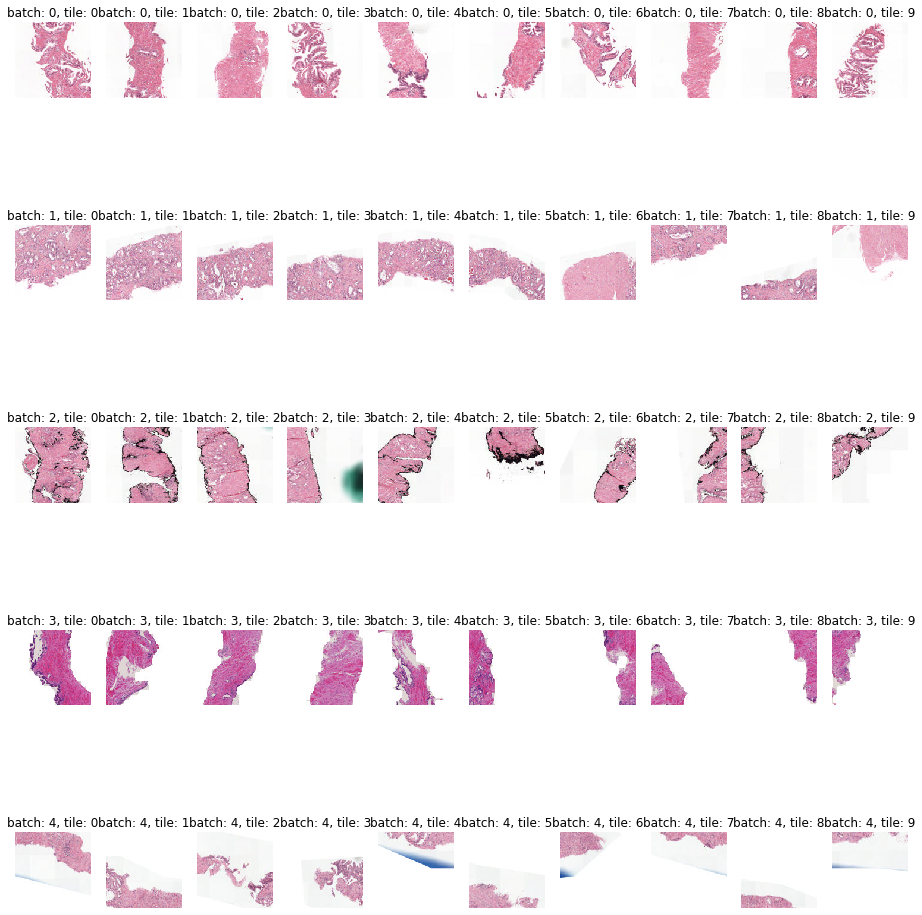

In [4]:
print(data.get_batch()[0].shape)
data.display_batch()

In [5]:
import tensorflow.keras.backend as K
def backend_reshape(x, new_shape):
    # casting a shape (bs, N, w/N, H, C) with batch shape None:
    # (-1,N,w/N, H, C), -1 handles the None argument
    return K.reshape(x, new_shape)

In [6]:

from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model

inputs = KL.Input(shape=(16,128,128,3), batch_size=8)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, 128, 128, 3)})(inputs)


eff_net = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(128, 128, 3))(x)
x = KL.Lambda(backend_reshape, arguments={'new_shape': (-1, 16, 4, 4, 1280)})(eff_net)
x = KL.Flatten()(x)
outputs = KL.Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.summary()

from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.00001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(8, 16, 128, 128, 3)]    0         
_________________________________________________________________
lambda (Lambda)              (128, 128, 128, 3)        0         
_________________________________________________________________
efficientnetb0 (Model)       (None, 4, 4, 1280)        4049571   
_________________________________________________________________
lambda_1 (Lambda)            (8, 16, 4, 4, 1280)       0         
_________________________________________________________________
flatten (Flatten)            (8, 327680)               0         
_________________________________________________________________
dense (Dense)                (8, 6)                    1966086   
Total params: 6,015,657
Trainable params: 5,973,634
Non-trainable params: 42,023
______________________________________________

In [8]:
preds = model.predict(data().take(1))
print(preds.shape)

(8, 6)


In [9]:
model.fit(data(), steps_per_epoch=1500, epochs=2)

Epoch 1/2
1500/1500 [==============================] - 730s 487ms/step - loss: 2.0974 - accuracy: 0.2337
Epoch 2/2
 162/1500 [==>...........................] - ETA: 10:25 - loss: 1.5256 - accuracy: 0.3843

KeyboardInterrupt: 

## Testing whether the batch layer hack fails

In [9]:
class DataLoaderPNG(BaseDataLoader):
    """ Class that handles the loading and processing of concat tile pooling.

    The input is assumed to be a dataset from list_files() function.
    The images in the data folder are expected to contain PNG images,
    and represent shards of a larger image according to concat tile pooling
    i.e. a single image is represented by a batch of multiple images
    which is expressed in the filename according to the pattern
    <fname>_<X>.png where X represents the total number of tiles per image
    """

    def __init__(self, ds_list, df, num_tiles, batch_size):
        """ Class initializer.
        
        Parameters
        ----------
        ds_list : Tensorflow TensorSliceDataset
            A dataset containing the paths to the images
        df : Pandas DataFrame
            Pandas dataframe containing the image_id, ISUP grade,
            and Gleason scores as columns.
        num_tiles : int
            The number of tiles. In case of PNG loader: the amount of tiles
            that were created, in case of TIFF loader: the amount of tiles
            to be created.
        batch_size : int
            The batch size that the processed Tensorflow dataset will yield.
            This batch size is also used during training networks

        Returns
        -------
        None.

        """
        super().__init__(ds_list, df, num_tiles, batch_size)
        
        # Initialize a TF dataset that returns (img/label) pairs
        self._ds = self.load_process2(self._batch_size)
        
        self._ds_iter = iter(self._ds)

    def _load_image(self, path):
        """
        Process an image from a path.

        Parameters
        ----------
        path : Tensor of byte strings
            The path to the image

        Returns
        -------
        image : Tensorflow image
            [M, N, 3] image in Tensor format

        """
        image = tf.io.read_file(path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.convert_image_dtype(image, tf.float32)
        return image
    
    def _load_label(self, isup):
        
        return tf.one_hot(tf.cast(isup, dtype=tf.int32), 6, dtype=tf.int32)
    
    def load_process(self, batch_size, shuffle_buffer_size=1000, cache=True):
        """
        Create the Tensorflow dataset pipeline.

        Parameters
        ----------
        batch_size : int
            The batch size the dataset will yield
        shuffle_buffer_size : int, optional
            The size of the shuffle buffer. Shuffle buffers have to be filled.
            Larger means better randomness, but more memory consumption.
            Lower is faster and uses less memory, but less randomness.
            The default is 1000.
        cache : bool or string, optional
            Whether to use a cache or not. The cache improves data loading for
            large datasets (unable to hold in memory). In case of a string
            the file must be named according to <path_to_folder/fname.tfcache>.
            In case the file does not exist, it will be created.
            The default is True.

        Returns
        -------
        Tensorflow dataset
            A tensorflow dataset that can be executed eagerly, and will yield
            batches of self._batch_size. Shuffle buffer sizes and cache
            behaviour are dependent on user input.
            The dataset is inexhaustible (repeats forever)

        """
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        # map the parsing functions to gather (img, label) pairs
        self._ds = self._ds_list.map(self._load_image,
                                     num_parallel_calls=AUTOTUNE)
        
        # use a batching process to acquire concat tile pooling batches
        self._ds = self._ds.batch(self._num_tiles)
        
        self._labels = self._label_ds.map(self._load_label,
                                          num_parallel_calls=AUTOTUNE)

        # label stuff
        self._ds = tf.data.Dataset.zip((self._ds, self._labels))
        
        # use cache(filename) to cache preprocessing work for datasets
        # that do not fit in memory
        if cache:
            if isinstance(cache, str):
                self._ds = self._ds.cache(cache)
            else:
                self._ds = self._ds.cache()

        self._ds = self._ds.shuffle(buffer_size=shuffle_buffer_size)
        
        # Repeat forever
        self._ds = self._ds.repeat()
        
        # Make an actual batch of examples
        self._ds = self._ds.batch(self._batch_size)

        # `prefetch` lets the dataset fetch batches in the background
        # while the model is training.
        self._ds = self._ds.prefetch(buffer_size=AUTOTUNE)
        return self._ds
    
    def get_batch(self):
        """ Retrieve a batch from the dataset.
        
        Returns
        -------
        TF Tensor
            A [batch_size, num_tiles, M, N, C] array
            of images in Tensor format
        """
        return next(self._ds_iter)
    
    def _load_label2(self, path):
        """
        Process labels from a path.
        
        Parameters
        ----------
        path : Tensor of bytes strings
            The path to the image, containing the image id

        Returns
        -------
        Tensor of int
            A TF Tensor containing an int with the ISUP grade

        """
        fname = tf.strings.split(path, '/')[-1]  # base filename of the object
        fname = tf.strings.split(fname, '.')[0]  # remove the .png extension
        fname = tf.strings.split(fname, '_')[0]  # remove underscore postfix
        
        # check at which index the fname equals the image id in the df
        # note: if sanity checked, it should return a monotic sequence
        # since the ds list is not shuffled (and neither the pandas df)
        idx = tf.where(tf.equal(self._image_id, fname))
        
        return tf.one_hot(tf.cast(self._isup[tf.squeeze(idx)], dtype=tf.int32), 6, dtype=tf.int32)
    
    def parse_img_label(self, path):
        img = self._load_image(path)
        label = self._load_label2(path)
        return img, label
    
    def load_process2(self, path, cache=True, shuffle_buffer_size=1000):
        """
        Create the Tensorflow dataset pipeline.

        Parameters
        ----------
        batch_size : int
            The batch size the dataset will yield
        shuffle_buffer_size : int, optional
            The size of the shuffle buffer. Shuffle buffers have to be filled.
            Larger means better randomness, but more memory consumption.
            Lower is faster and uses less memory, but less randomness.
            The default is 1000.
        cache : bool or string, optional
            Whether to use a cache or not. The cache improves data loading for
            large datasets (unable to hold in memory). In case of a string
            the file must be named according to <path_to_folder/fname.tfcache>.
            In case the file does not exist, it will be created.
            The default is True.

        Returns
        -------
        Tensorflow dataset
            A tensorflow dataset that can be executed eagerly, and will yield
            batches of self._batch_size. Shuffle buffer sizes and cache
            behaviour are dependent on user input.
            The dataset is inexhaustible (repeats forever)

        """
        AUTOTUNE = tf.data.experimental.AUTOTUNE
        
        # map the parsing functions to gather (img, label) pairs
        self._ds = self._ds_list.map(self.parse_img_label,
                                     num_parallel_calls=AUTOTUNE)
        

        # use cache(filename) to cache preprocessing work for datasets
        # that do not fit in memory
        if cache:
            if isinstance(cache, str):
                self._ds = self._ds.cache(cache)
            else:
                self._ds = self._ds.cache()

        self._ds = self._ds.shuffle(buffer_size=shuffle_buffer_size)
        
        # Repeat forever
        self._ds = self._ds.repeat()
        
        # Make an actual batch of examples
        self._ds = self._ds.batch(self._batch_size)

        # `prefetch` lets the dataset fetch batches in the background
        # while the model is training.
        self._ds = self._ds.prefetch(buffer_size=AUTOTUNE)
        return self._ds
    
    def display_batch(self, batch=None, max_batch_size=5, max_tile_size=10):
        """ Plot a batch of images.
        
        Parameters
        ----------
        batch : TF Tensor or numpy array, optional
            A [batch_size, num_tiles, M, N, C] array of images.
            The default is None.
        max_batch_size : int, optional
            The amount of the batch size to plot.
            Should be <= self._batch_size.The default is 5.
        max_tile_size : int, optional
            The number of tiles to plot, should be <= num_tiles.
            The default is 10.

        Returns
        -------
        None.

        """
        if batch is None:
            batch = self.get_batch()
         
        # The batch is [BS, NT, W, H, C], this is not a supported format
        # Loop over the batch (rows) and num_tiles (columns) and display
        img_batch, label_batch = batch
        
        fig, ax = plt.subplots(max_batch_size, max_tile_size, figsize=(16, 18))
            
        # Plot each image in the dataframe
        for batch in range(max_batch_size):
            for tile in range(max_tile_size):
                ax[batch, tile].imshow(img_batch[batch, tile, ...])
                ax[batch, tile].axis('off')
                ax[batch, tile].set_title(f'batch: {batch}, tile: {tile}')
                
    def print_fname_order(self, head=10):
        """Prints the fname order of ds_list, image_id, and df."""
        check_ds = self._ds_list.filter(lambda x: tf.strings.regex_full_match(x, ".*_0.png"))
        
        print("lists order as processed by tensorflow environment")
        for x, y, isup in zip(check_ds.take(head), self._image_id, self._isup):
            print("images:", Path(x.numpy().decode('utf8')).stem,
                  "labels:", y.numpy().decode('utf8'),
                  "isup grade", isup.numpy())

        print("original pandas dataframe")
        print(self._df[0:head])
        
    def __call__(self):
        return self._ds

In [ ]:
data2 = DataLoaderPNG(list_dataset, df, num_tiles=16, batch_size=32)

In [ ]:
ds = data2()

for x,y in ds.take(1):
    print(x.shape, y)

In [ ]:
from tensorflow.keras import layers as KL
from tensorflow.keras.models import Model

eff_net = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_tensor=KL.Input((128,128,3), batch_size=32))
x = KL.Flatten()(eff_net.output)
outputs = KL.Dense(6, activation='softmax')(x)

model = Model(inputs=eff_net.input, outputs=outputs)

from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.00001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
model.fit(data2(), steps_per_epoch=3000, epochs=2)

In [ ]:
model.summary()

# Forget about this for now

In [ ]:
class DataLoaderTIFF(BaseDataLoader):
    
    def __init__(self, ds_list, df, num_tiles, batch_size):
        super().__init__(ds_list, df, num_tiles, batch_size)
    
    
    def tile_tf(self, pad_values, N ,sz):
    
        def tile(img, img_shape, pad_values=pad_values, N=N, sz=sz):
            print("img", img.shape, 
                  "img shape", img_shape,
                  "img_shape 0", img_shape[0],
                  "img shape 1", img_shape[1],
                  "img shape 2", img_shape[2],
                  "pad values", pad_values, 
                  "N", N, 
                  "sz", sz)

            # Append the results in here
            # pad values should be 255 for the image, 0 for mask
            result = []

            shape = img.shape

            # Pad the image if it is not perfectly divisible in tiles 
            pad0,pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
            img = np.pad(img, [
                [pad0 // 2, pad0 - pad0 // 2], 
                [pad1 // 2, pad1 - pad1 // 2], 
                [0, 0]
            ], constant_values=pad_values)

            # [W, H, C] to [W/, s, H/, s, C]
            img = img.reshape(img.shape[0]//sz,sz,img.shape[1]//sz,sz,3)

            # Transpose to [W/s, H/s,s , s_h, C], reshaped to [(W/s) * (H/s), s, s, C]
            # Note: we now have grid of (W/s) * (H/s) with tiles of size s * s
            img = img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)

            # An extraordinary case, probably does not happen...
            if len(img) < N:
                # pad the image so it makes up 1 tile
                img = np.pad(img, [
                    [0, N - len(img)], 
                    [0, 0], [0, 0], [0, 0]
                ], constant_values=pad_values)

            # Reshape to [(W/s) * (H/s), s * s * c]
            # Sum last axis, so that it becomes [(W/s) * (H/s), 1]
            # Get the indices of the tiles with the least amount of background
            # These tiles have the lowest summed values
            idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]

            # Resort the images according to idxs, tiles are now
            # sorted in ascending order by background occurence
            img = img[idxs]

            # Append to the result list
            for i in range(len(img)):
                result.append({'img':img[i], 'idx':i})
            return result
        
        return tile
        
    def _load_image(self, path):
        
        
        def load_wsi_level(path):

            # TODO: replace [-1] with general level loading
            image = skimage.io.MultiImage(path.numpy().decode('utf8'))[-1]
            shape = image.shape
            return image, shape.astype('int32')
        
        image = tf.io.read_file(path)
        image, shape = tf.py_function(load_wsi_level, [path], [tf.float32, tf.int32])
        
        print("shape in fun", shape[0].get_shape())
        shape.set_shape(tf.TensorShape([3,]))
        image.set_shape(tf.TensorShape([None, None, 3]))
        print(shape[0].eval())
        image = tf.reshape(image, [shape[0], shape[1], shape[2]])
        
        return image, shape
    
    def _load_image2(self, path):
        image = tf.io.read_file(path)
        image = tfio.experimental.image.decode_tiff(image, name=None)
        return image
    
    def _load_mask(self, path):
        pass
    
    def _parse_img_label(self, path):
        z = self._load_image2(path)
        return z
    
    def load_process(self):
        ds = self._ds_list.map(self._parse_img_label)
        
        #ds = ds.map(self.tile_tf(pad_values=255, N=16, sz=128))
        return ds

In [ ]:
tiff_files = (DATA_DIR / 'train_images').glob('*.tiff')
tiff_files = list(tiff_files)
tiff_files = [str(x) for x in tiff_files]
tiff_tensor = tf.data.Dataset.from_tensor_slices(tiff_files)


In [ ]:
data = DataLoaderTIFF(tiff_tensor, df, num_tiles=16, batch_size=32 )
data.load_process()

In [ ]:
for x in data.load_process().take(2):
    print(x[1].numpy())
    

In [ ]:
print(tfio.__version__)

In [ ]:
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio

print(tfio.__version__)
print(tf.__version__)


tiff_files = Path('../data/example').glob('*.tif')
tiff_files = list(tiff_files)
tiff_files = [str(x) for x in tiff_files]
tiff_tensor = tf.data.Dataset.from_tensor_slices(tiff_files)
    
for x in tiff_tensor.take(1):
    print(x)

def parse_img(path):
    image = tf.io.read_file(path)
    image = tfio.experimental.image.decode_tiff(image, index=2,name=None)
    return image

def parse_img_info(path):
    image = tf.io.read_file(path)
    image = tfio.experimental.image.decode_tiff_info(image,name=None)
    return image

ds_info = tiff_tensor.map(parse_img_info)

for x in ds_info.take(1):
    print(x)

ds = tiff_tensor.map(parse_img)

for x in ds.take(1):
    print(x)